## Classifying From Tabular Data

In [1]:
# To classify tabular data we use fastai.tabular
from fastai.tabular.all import * 
import matplotlib.pyplot as plt
import numpy
import random
import unittest

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import datetime


## Reading Data

In [2]:
# Path to data set
# Test data get partitioned into a separate file already now
from pathlib import Path
data_path = Path('./data/mecs/MECS_2-Phase-Steels.csv')

In [3]:
# Reading CSV file containing training and validation data
import pandas as pd
dataframe = pd.read_csv(data_path, sep=';')

# Looking at the first data
print(dataframe.info())
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10735 entries, 0 to 10734
Columns: 107 entries, class to std. convexity
dtypes: float64(106), object(1)
memory usage: 8.8+ MB
None


,class,equiv. diameter,major axis length,minor axis length,perimeter,equiv. radius,max feret diameter,min feret diameter,mean feret diameter,convex perimeter,...,std. relativ area,std. convex area/filled area,std. axial ratio,std. aspect ratio,std. roundness,std. circularity,std. sphericity,std. convex per./filled per.,std. form factor,std. convexity
0,category_3,15.225748,11.478270,6.516211,101.586092,7.612874,28.476331,14.601479,21.538905,69.846721,...,0.002630,0.360265,0.247471,0.172865,0.167522,0.150141,0.991127,0.257917,0.254766,0.725854
1,category_3,1.151113,0.974243,0.385487,5.609659,0.575557,2.580962,0.888856,1.734909,5.555157,...,0.193671,0.345320,0.108488,0.097143,0.104520,0.107560,0.357665,0.126119,0.195196,0.270121
2,category_3,1.450391,1.068283,0.524281,5.629028,0.725196,2.312959,1.144310,1.728635,5.545392,...,0.102618,0.441363,0.205836,0.167468,0.075052,0.079354,0.199565,0.134383,0.116518,0.255049
3,category_3,3.561641,2.350421,1.400185,13.099335,1.780821,5.162738,3.039382,4.101060,12.632860,...,0.040841,0.347140,0.234101,0.159523,0.160860,0.144939,1.299666,0.328635,0.253970,1.025188
4,category_3,6.676158,5.226249,2.784733,35.279133,3.338079,12.536480,6.907373,9.721926,30.297397,...,0.009716,0.257991,0.253047,0.162753,0.156650,0.134192,1.073103,0.273935,0.238783,0.793738


## Data Loading and Encoding 

In [4]:
batch_size = 4
n_features = len(dataframe.columns)-1

def extract_numpy_from_df( dataframe, y_column ):
    X = dataframe.drop(columns=dataframe.columns[y_column]).to_numpy()
    Y = dataframe.iloc[:,y_column].to_numpy()

    return X,Y

def clean_data( dataframe ):
    dataframe.dropna(inplace=True)
    if dataframe.shape[0] < 100:
        raise ValueError("Data set too small after cleaning, less than 100 rows") 

    return dataframe

    
def get_validation_and_training_indices( dataset_length ):
    random.seed(42)
    indices_train = random.sample( range( dataset_length ), int( dataset_length * 0.8 ) )
    indices_validation = list( set(range( dataset_length )) - set(indices_train) )
    
    return indices_train,indices_validation

def normalize( X ):
    if X.std() == 0:
        raise ZeroDivisionError("The data cant be normalized, the standard deviation is zero. Data is constant.")
    else:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        return X


def hot_1_encode( Y, codes ):
    Y_encoded = numpy.zeros( (Y.shape[0], len(codes)) )
    for i in range( Y.shape[0] ):
        Y_encoded[i][codes[Y[i]]] = 1
    
    return Y_encoded

def create_batch( permutation, batch_no, batch_size, X ):
    x_batch = torch.zeros( [ batch_size, X.shape[1] ], dtype=torch.float32 )
    for i in range( batch_size ):
        x_batch[i] = torch.tensor( X[ permutation[batch_no*batch_size + i] ] )
    
    return x_batch

codes = { 'category_1' : 0, 'category_2' : 1, 'category_3' : 2 }

dataframe = clean_data( dataframe )
X,Y = extract_numpy_from_df( dataframe, 0 )

indices_train,indices_validation = get_validation_and_training_indices( X.shape[0] )

X   = normalize( X )
Y   = hot_1_encode( Y, codes )

In [5]:
class TestNotebook(unittest.TestCase):

    def test_clean_data(self):
        data_too_small = pd.DataFrame({'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

        data_with_nan = pd.DataFrame({'Value': np.random.randn(200)})
        nan_indices = np.random.choice(data_with_nan.index, size=20, replace=False)  # Choose 20 indices to be NaN
        data_with_nan.loc[nan_indices, 'Value'] = np.nan
        
        self.assertRaises(ValueError, clean_data,data_too_small)
        self.assertEqual(clean_data(data_with_nan).shape[0], 180)
        

    def test_extract_numpy_from_df(self):
        df = pd.DataFrame({'A': [1, 2, 3, 4, 5], 'B': [6, 7, 8, 9, 10], 'C': [11, 12, 13, 14, 15], 'D': [16, 17, 18, 19, 20]})
        X,Y = extract_numpy_from_df(df, 2)

        self.assertEqual(X.shape, (5,3))
        self.assertEqual(Y.shape[0], 5)
        self.assertEqual(Y[0], 11)

        X,Y = extract_numpy_from_df(df, 0)
        self.assertEqual(X.shape, (5,3))
        self.assertEqual(Y.shape[0], 5)
        self.assertEqual(Y[0], 1)

    def test_normalize(self):
        X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        X = normalize(X)
        self.assertAlmostEqual(X.mean(), 0)
        self.assertAlmostEqual(X[1].mean(), 0)
        
        X = np.array([np.ones(5)])
        self.assertRaises(ZeroDivisionError, normalize, X)

    def test_hot_1_encode(self):
        Y = np.array(['category_1', 'category_2', 'category_3', 'category_1', 'category_2'])
        Y_encoded = hot_1_encode(Y, codes)

        self.assertEqual(Y_encoded.shape, (5, 3))
        self.assertEqual(Y_encoded[0][0], 1)
        self.assertEqual(Y_encoded[1][1], 1)
        self.assertEqual(Y_encoded[2][2], 1)
        self.assertEqual(Y_encoded[3][0], 1)
        self.assertEqual(Y_encoded[4][1], 1)
    
    def test_get_validation_and_training_indices(self):
        indices_train, indices_validation = get_validation_and_training_indices(100)
        self.assertEqual(len(indices_train), 80)
        self.assertEqual(len(indices_validation), 20)
        self.assertEqual(set(indices_train).intersection(set(indices_validation)) == set(), True)

    def test_create_batch(self):
        permutation = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30]])
        x_batch = create_batch(permutation, 1, 4, X)
        
        self.assertEqual(x_batch.shape, (4, 3))
        self.assertEqual(x_batch[0][0], 13)
        self.assertEqual(x_batch[1][1], 17)
        self.assertEqual(x_batch[2][2], 21)
        self.assertEqual(x_batch[3][0], 22)

unittest.main(argv=[''], verbosity=2, exit=False)


test_clean_data (__main__.TestNotebook) ... ok
test_create_batch (__main__.TestNotebook) ... ok
test_extract_numpy_from_df (__main__.TestNotebook) ... ok
test_get_validation_and_training_indices (__main__.TestNotebook) ... ok
test_hot_1_encode (__main__.TestNotebook) ... ok
test_normalize (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.022s

OK


## Creating a Network Architecture

In [6]:
def create_model( n_in, n_hidden, n_out ):
    layers = []
    
    # Input layer to first hidden layer
    layers.append(nn.Linear(n_in, n_hidden[0]))
    layers.append(nn.ReLU())
    
    # Adding subsequent hidden layers
    for i in range(1, len(n_hidden)):
        layers.append(nn.Linear(n_hidden[i-1], n_hidden[i]))
        layers.append(nn.ReLU())
    
    # Output layer
    layers.append(nn.Linear(n_hidden[-1], n_out))
    
    # Create the sequential model
    model = nn.Sequential(*layers)
    return model

model = create_model(X.shape[1], [50, 25], Y.shape[1])

In [7]:
print(model)

Sequential(
  (0): Linear(in_features=106, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=3, bias=True)
)


## Training Loop

In [8]:
def accuracy_metric( y, y_hat ):
    y     = torch.argmax(y, dim=1).to(torch.float32)
    y_hat = torch.argmax(y_hat, dim=1).to(torch.float32)
    difference = y_hat-y
    return 1.0 - torch.mean( torch.abs( difference ) ).item() 

def train_one_epoch( epoch_index, indices_train, X, Y, optimizer, loss_fn, batch_size, writer ):
    no_iterations = int( len(indices_train) / batch_size )
    losses           = []
    accuracies       = []
    
    for batch_no in range( no_iterations ):
        x_batch = create_batch( indices_train, batch_no, batch_size, X )
        y_batch = create_batch( indices_train, batch_no, batch_size, Y )
        
        optimizer.zero_grad()
        y_hat = model( x_batch )
        loss = loss_fn( y_hat, torch.argmax(y_batch, dim=1) ) # CrossEntropyLoss expects the class index, not the one-hot encoding
        loss.backward()
        optimizer.step()
        
        accuracy = accuracy_metric( y_batch, y_hat )
        losses.append( loss.item() )
        accuracies.append( accuracy )

        writer.add_scalar("Loss/train", np.mean(losses), epoch_index)
        writer.add_scalar("Accuracy/train", np.mean(accuracies), epoch_index)

    return np.mean(losses), np.mean(accuracies)



In [13]:
model = create_model(X.shape[1], [50, 25], Y.shape[1])
optimizer = torch.optim.Adam( params = model.parameters(), lr=0.001 )
loss_fn   = torch.nn.CrossEntropyLoss()

losses           = []
accuracies       = []
n_epochs = 50
for i in range (n_epochs):
    metrics = train_one_epoch( i, indices_train, X, Y, optimizer, loss_fn, 32, writer )
    loss_per_epoch, accuracy_per_epoch = metrics
    losses.append(loss_per_epoch)
    accuracies.append(accuracy_per_epoch)
    print("epoch",i,"/",n_epochs,"accuracy",accuracy_per_epoch)

epoch 0 / 50 accuracy 0.8025886194029851
epoch 1 / 50 accuracy 0.9203591417910447
epoch 2 / 50 accuracy 0.9378498134328358
epoch 3 / 50 accuracy 0.9457789179104478
epoch 4 / 50 accuracy 0.9505597014925373
epoch 5 / 50 accuracy 0.9542910447761194
epoch 6 / 50 accuracy 0.9576725746268657
epoch 7 / 50 accuracy 0.9622201492537313
epoch 8 / 50 accuracy 0.9645522388059702
epoch 9 / 50 accuracy 0.9673507462686567
epoch 10 / 50 accuracy 0.9692164179104478
epoch 11 / 50 accuracy 0.9718983208955224
epoch 12 / 50 accuracy 0.972714552238806
epoch 13 / 50 accuracy 0.9734141791044776
epoch 14 / 50 accuracy 0.9751632462686567
epoch 15 / 50 accuracy 0.9772621268656716
epoch 16 / 50 accuracy 0.9783115671641791
epoch 17 / 50 accuracy 0.9777285447761194
epoch 18 / 50 accuracy 0.9807602611940298
epoch 19 / 50 accuracy 0.9825093283582089
epoch 20 / 50 accuracy 0.9822761194029851
epoch 21 / 50 accuracy 0.9832089552238806
epoch 22 / 50 accuracy 0.9848414179104478
epoch 23 / 50 accuracy 0.9850746268656716
epo

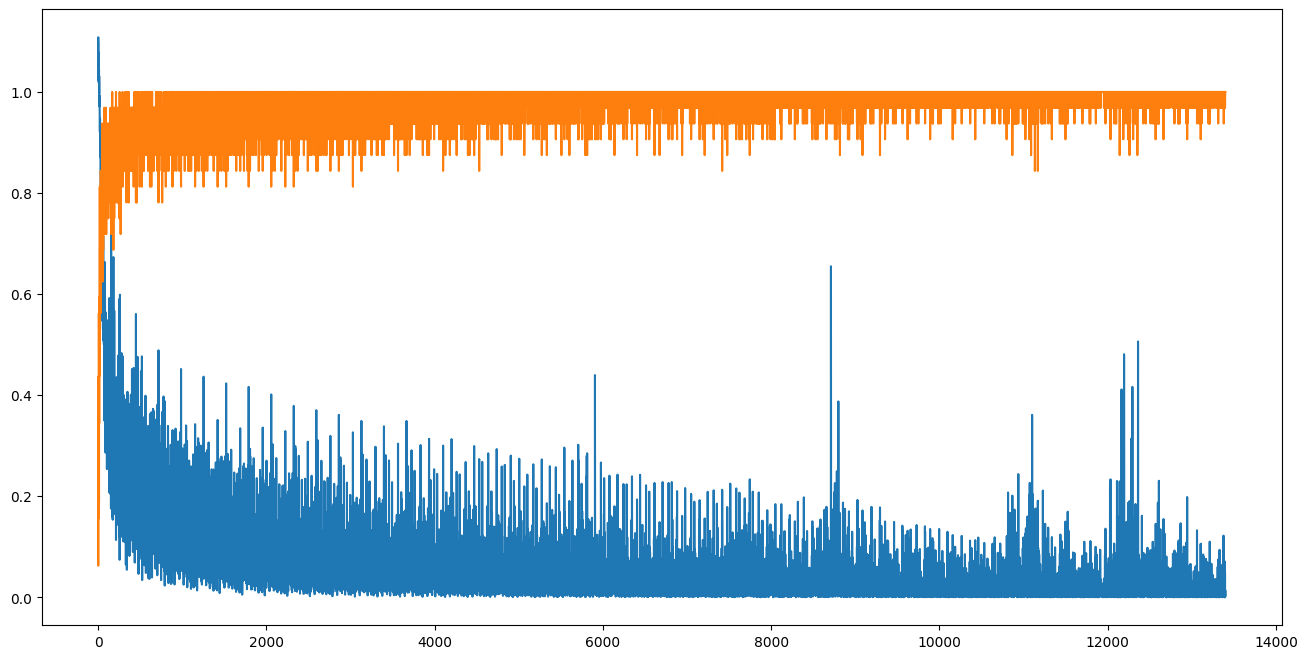

In [10]:
fig,axis = plt.subplots( 1,1, figsize=(16,8) )
axis.plot( losses )
axis.plot( accuracies )
plt.show()

## Hyper Parameter Tuning

Now, we experimentally determine optimal training parameters. You will need to organize your source
code to allow for the following experiments. Consider that a network is initialized with random values
only when the model is created. If training is interrupted and continued, weights and biases are preserved.
1. Find an optimal learning rate. Argue which rates you tested and how you determined an optimal
value.
2. Find an optimal learning batch size. Argue which batch sizes you tested and how you determined
an optimal value.
3. Find an optimal network architecture (number of layers and nuber of features for each layer). Argue
which architectures you tested and how you determined an optimal setup.
I needed the following time to complete the task:



In [9]:
def validate_one_epoch( epoch_index, indices_val, X, Y, model, loss_fn, batch_size, writer ):
    no_val_batches = int( len(indices_val) / batch_size )
    losses = []
    accuracies = []
    
    for batch_no in range( no_val_batches ):
        x = create_batch( indices_val, batch_no, batch_size, X )
        y = create_batch( indices_val, batch_no, batch_size, Y )
        
        with torch.no_grad():
            y_pred = model( x )
            loss = loss_fn( y_pred, torch.argmax(y, dim=1) )
            accuracy = accuracy_metric( y, y_pred )
            losses.append( loss.item() )
            accuracies.append( accuracy )

        writer.add_scalar("Loss/val", np.mean(losses), epoch_index)
        writer.add_scalar("Accuracy/val", np.mean(accuracies), epoch_index)
    
    return np.mean( losses ), np.mean( accuracies )

In [11]:
for lr in [0.1, 0.01, 0.001, 0.0001]:
    for batch_size in [32, 64, 128]:
        for hidden_layers in [[30,15],[50, 25], [100, 50, 25]]:
            writer = SummaryWriter(comment=f"lr_{lr}_bs_{batch_size}_layers_{hidden_layers}")
            model = create_model(X.shape[1], hidden_layers, Y.shape[1])
            optimizer = torch.optim.Adam( params = model.parameters(), lr=lr )
            loss_fn   = torch.nn.CrossEntropyLoss()
            
            losses_train           = []
            accuracies_train       = []
            losses_validation      = []
            accuracies_validation  = []
            n_epochs = 50

            for i in range (n_epochs):
                metrics_train = train_one_epoch( i, indices_train, X, Y, optimizer, loss_fn, batch_size, writer )
                losses_train.append(metrics_train[0])
                accuracies_train.append(metrics_train[1])
                metrics_val = validate_one_epoch( i, indices_validation, X, Y, model, loss_fn, batch_size, writer )
                losses_validation.append(metrics_val[0])
                accuracies_validation.append(metrics_val[1])
                print("epoch",i,"/",n_epochs,"loss_train:",metrics_train[0],"acc_train:",metrics_train[1],"loss_val:",metrics_val[0],"acc_val:",metrics_val[1])

            print("Validation accuracy for lr",lr,"bs",batch_size,"hl",hidden_layers,":",accuracies_validation[-1])

epoch 0 / 50 loss_train: 0.9858759661663824 acc_train: 0.48903917910447764 loss_val: 0.9614936905120736 acc_val: 0.5013992537313433
epoch 1 / 50 loss_train: 0.9554073583723893 acc_train: 0.49486940298507465 loss_val: 0.9617459996422725 acc_val: 0.5013992537313433
epoch 2 / 50 loss_train: 0.9555306078782723 acc_train: 0.494169776119403 loss_val: 0.9618418697100967 acc_val: 0.5013992537313433
epoch 3 / 50 loss_train: 0.9555803470647157 acc_train: 0.49486940298507465 loss_val: 0.9618892367206403 acc_val: 0.5013992537313433
epoch 4 / 50 loss_train: 0.9556065315186087 acc_train: 0.49486940298507465 loss_val: 0.961916565005459 acc_val: 0.5013992537313433
epoch 5 / 50 loss_train: 0.9556221719553222 acc_train: 0.49486940298507465 loss_val: 0.9619334117690129 acc_val: 0.5013992537313433
epoch 6 / 50 loss_train: 0.9556322206756962 acc_train: 0.49486940298507465 loss_val: 0.9619446121045013 acc_val: 0.5013992537313433
epoch 7 / 50 loss_train: 0.9556390169396329 acc_train: 0.49486940298507465 loss

In [13]:
dataframe = pd.read_csv("./data/iris_data.csv", sep=";")
codes = { 'Iris-setosa' : 0, 'Iris-versicolor' : 1, 'Iris-virginica' : 2 }

X, Y = extract_numpy_from_df( dataframe, 4 )
indices_train,indices_validation = get_validation_and_training_indices( X.shape[0] )

X   = normalize( X )
Y   = hot_1_encode( Y, codes )

for lr in [0.001, 0.0001]:
    for batch_size in [5, 10]:
        for hidden_layers in [[50, 25], [100, 50, 25]]:
            writer = SummaryWriter(log_dir= 'runs/iris', comment=f"lr_{lr}_bs_{batch_size}_layers_{hidden_layers}")
            model = create_model(X.shape[1], hidden_layers, Y.shape[1])
            optimizer = torch.optim.Adam( params = model.parameters(), lr=lr )
            loss_fn   = torch.nn.CrossEntropyLoss()
            
            losses_train           = []
            accuracies_train       = []
            losses_validation      = []
            accuracies_validation  = []
            n_epochs = 50

            for i in range (n_epochs):
                metrics_train = train_one_epoch( i, indices_train, X, Y, optimizer, loss_fn, batch_size, writer )
                losses_train.append(metrics_train[0])
                accuracies_train.append(metrics_train[1])
                metrics_val = validate_one_epoch( i, indices_validation, X, Y, model, loss_fn, batch_size, writer )
                losses_validation.append(metrics_val[0])
                accuracies_validation.append(metrics_val[1])
                print("epoch",i,"/",n_epochs,"loss_train:",metrics_train[0],"acc_train:",metrics_train[1],"loss_val:",metrics_val[0],"acc_val:",metrics_val[1])

            print("Validation accuracy for lr",lr,"bs",batch_size,"hl",hidden_layers,":",accuracies_validation[-1])

epoch 0 / 50 loss_train: 1.047047646149345 acc_train: -0.0695652274981789 loss_val: 0.976997305949529 acc_val: 0.29999999205271405
epoch 1 / 50 loss_train: 0.9152113354724386 acc_train: 0.4956521625104158 loss_val: 0.8485518793265024 acc_val: 0.5666666602094969
epoch 2 / 50 loss_train: 0.7387337710546411 acc_train: 0.7478260812552079 loss_val: 0.7074128886063894 acc_val: 0.6666666542490324
epoch 3 / 50 loss_train: 0.5613305128138998 acc_train: 0.8260869532823563 loss_val: 0.5963465571403503 acc_val: 0.6666666567325592
epoch 4 / 50 loss_train: 0.4280287986216338 acc_train: 0.8695652147997981 loss_val: 0.527994729578495 acc_val: 0.6666666567325592
epoch 5 / 50 loss_train: 0.3421871901854225 acc_train: 0.8869565200546513 loss_val: 0.48523737117648125 acc_val: 0.7333333293596903
epoch 6 / 50 loss_train: 0.28436223352732864 acc_train: 0.9130434769651165 loss_val: 0.4550500263770421 acc_val: 0.7666666631897291
epoch 7 / 50 loss_train: 0.24079678159045137 acc_train: 0.9217391292686048 loss_va